<a href="https://colab.research.google.com/github/androbaza/image-processing-matlab/blob/main/Canny_Edge_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
from scipy.ndimage import gaussian_filter
from scipy import signal, misc
from skimage.color import rgb2grey
import matplotlib.image as mpim
import matplotlib.pyplot as plt
import numpy as np

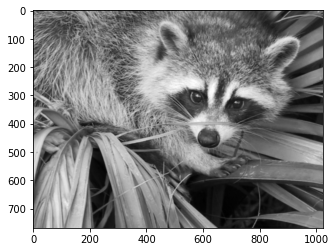

In [128]:
# image = mpim.imread('valve.png')
# image = rgb2grey(fig)
image = misc.face(True)
image = gaussian_filter(image, sigma = 1.1)
plt.imshow(image, cmap="gray")

In [135]:
def scharr(image):
  kernel = np.array([[47, 0, -47], [162, 0, -162], [47, 0, -47]])
  # kernel = np.array([[3, 0, -3], [10, 0, -10], [3, 0, -3]])

  convX = signal.convolve(image, kernel, mode='same')
  convY = signal.convolve(image, kernel.T, mode='same')

  G = np.sqrt(np.square(convX) + np.square(convY))
  G *= 255 / G.max()

  Th = np.arctan2(convX, convY)

  return G, Th

254.99999999999997

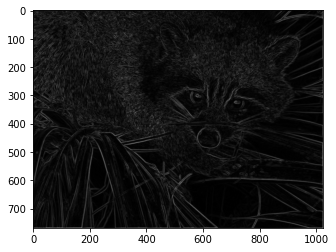

In [136]:
G, Th = scharr(image)
plt.imshow(G, cmap="gray")